# **EE 488 AI Convergence Capstone Design : Anomaly Detection**
## **HW3 : Classification Task**
Anomaly detection can be done by various pretext tasks. In this session, we will do anomaly detection with classification as a pretext task on the MNIST dataset.


This code is developed to apply the ArcFace loss to the classification model.

WIth ArcFace, the anomaly score $A$ is given by the Softmax probability obtained from the logit function $l_i$.

$ l_i = s \cos \theta_i = s \frac{ \mathbf{w}_i^\top \mathbf{z}}{||\mathbf{w}_i|| ||\mathbf{z}||}, $  
$A =  1 - \mathrm{max}_{i} \Big[ \frac{ e^{ l_i } }{   \sum_{j } e^{ l_j   }}  \Big]$         -- (Eq. 1)

for the feature $\mathbf{z}$ extracted from the feature extractor and the learned parameter $\mathbf{w}_i$ for the $i$th class.

During training, the model is trained to minimize the cross-entropy with an angular margin $m$ applied to the ground-truth label $i$:

$\mathcal{L} =  - \log \left( \frac{ e^{ s  \cos \left(\theta_{i} + m \right) } }{   e^{s  \cos \left(\theta_{i} + m \right)  } +   \sum_{j \neq i} e^{ s  \cos \theta_{j}   }}   \right)$

\\

**Problem 1**. [3 pts]

Train the model for two cases with NORMAL_NUM =[0,1,2,3] and NORMAL_NUM=[0,1,2,3,4,5,6,7,8], respectively (ANOMAL_NUM=[9] for both cases). Compare scatter plots and ROC-AUCs, and discuss why you have similarities or differences in results.

\\

**Problem 2**. [3 pts]

Change the anomaly scores of Eq. 1 using the logit

$ l_i^\prime = \begin{cases} s \cos (\theta_i+m)  & \text{for ground-truth label } i \\ s \cos (\theta_i)  & \text{otherwise} \end{cases}$  

$A_2 =  1 - \mathrm{max}_{i} \Big[ \frac{ e^{ l_i^\prime } }{   \sum_{j } e^{ l_j^\prime   }}  \Big]$         -- (Eq. 2)

Run the code using this anomaly score (NORMAL_NUM=[0,1,2,3,4,5,6,7,8]) and compare the result with that from Problem 1. Discuss why you have better/worse performance with the modified anomaly score.

\\
**Problem 3**. [3 pts]

Modify this code to detect anomalies using the plain cross-entropy loss without using the ArcFace loss. The model should produce logits according to the formula $l_i = \mathbf{w}_i^\top \mathbf{z}$. The loss function for training is the plain cross-entropy loss without margin $m$:
$\mathcal{L} =  - \log \left( \frac{ e^{ l_i } }{   \sum_{j } e^{ l_j   }}   \right)$

The anomaly score is the same as Eq. 1.
Compare the ROC-AUC, histogram, scatter plot of (A) with those from the original code. Discuss your results.  

\\
**Problem 4**. [1 pts]
Describe any ideas to improve the performance of the original code.



## 1. Import packages
New library imported for this project:
- `Scikit-learn` package: includes useful tools for data analysis & preprocessing (https://scikit-learn.org/stable/)
  - We use this package for `anomaly score` metrics
- `Matplot` library: for plotting graphs
- `Torchinfo`: summarizes and print formatted `model information`

In [1]:
! pip install --upgrade numpy==1.24.4

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Parameter
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn import metrics
from sklearn.manifold import TSNE
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
# import torchsummary
import numpy as np
import math

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda:0 device


In [5]:
plt.rc('font', size=20)

## 2. Hyperparameters
Parameter `ANOMALY_NUM` represents the numbers considered as anomalies.
`TEMPSC` and `LBSMOOTH` are parameters for temperature scaling and label smoothing, respectively.

Here, you can change EPOCHS and BATCH, but **other parameters should remain unchanged** (unless instructed in the HW assignment).




In [6]:
EPOCHS = 5            # Number of epochs to train
BATCH = 256          # Minibatch size

ORGCLASS_NUM = 10       # Num of original classes (10: 0 to 9)
ANOMALY_NUM = [9]   # (list) Digits will be used as anomalous data
NORMAL_NUM =  [0,1,2,3,4,5,6,7,8]   # (list) Digits used as normal data

EMB_SIZE = 3    # latent embedding size
TEMPSC = 1.0    # temperature parameter (for temperature scaling)
LBSMOOTH = 0    # label smoothing parameter

MARGIN = 0.5    # margin parameterin radian: 3x degrees
SCALE = 32      # scaling parameter s of logit

APPLY_MARGIN=True
USE_ARCFACE=False

## 3. Dataset and Dataloader

Here we use MNIST dataset.
The datatype of the dataset is a TorchTensor of tuples: (`image tensor`, `target label`)

The dimensions of an image tensor is (`channel`=1, `width`=28, `height` =28)

Here, we use `Subset` package in `torch.utils.data` to build two sub-datasets (validation, test).


In [7]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=True)

train_idx = [i for i,v in enumerate(mnist_train) if v[1] in NORMAL_NUM]         # get a list of indices with NORMAL_NUM, v is the tuple of (image tensor, label)
train_dataset = Subset(mnist_train,train_idx)                       # get a subset of dataset using train_idx

testdigit = ANOMALY_NUM + NORMAL_NUM                                            # join two list
test_idx =[i for i,v in enumerate(mnist_test) if v[1] in testdigit]
Num_test = int(len(test_idx)/2)

test_dataset = Subset(mnist_test,test_idx[:Num_test])
val_dataset = Subset(mnist_test,test_idx[Num_test:])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)


Dataset length is like below.

In [8]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

54051
5000
5000


In [9]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_feature=128, out_feature=10575, s=32.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.s = s
        self.m = m
        self.weight = Parameter(torch.Tensor(out_feature, in_feature))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)

        # make the function cos(theta+m) monotonic decreasing while theta in [0°,180°]
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, x, p):
        # cos(theta)
        cosine = F.linear(F.normalize(x), F.normalize(self.weight),bias=None)
        cosine = cosine.clip(-1+1e-7, 1-1e-7)

        # cos(theta + m)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where((cosine - self.th) > 0, phi, cosine - self.mm)

        output = (p * phi) + ((1.0 - p) * cosine)
        output *= self.s  # logits

        return output, cosine # return logits with margin


## 4. Define a DNN model
Now, you will use CNN classifier.

In [10]:
class ClassificationCNNModel(nn.Module):
    def __init__(self, nclass=len(NORMAL_NUM), embsize = EMB_SIZE, scale = SCALE, margin=MARGIN, use_arcface=False):
        super(ClassificationCNNModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1,10,kernel_size = (5,5)),
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Conv2d(10,20,kernel_size = (5,5)),
            nn.Dropout2d(),
            nn.BatchNorm2d(20),
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            nn.ReLU(),
        )
        self.features = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Linear(50, embsize),
        )
        self.use_arcface = use_arcface
        if use_arcface:
            self.classifier = ArcMarginProduct(in_feature=embsize, out_feature=nclass, s=scale, m=margin, easy_margin=False)
        else:
            self.classifier = nn.Linear(embsize, nclass)  # new linear layer

    def forward(self, x, p):
        feature = self.feature_extractor(x)
        feature = feature.reshape(feature.shape[0],-1)
        feature = self.features(feature)
        if self.use_arcface:
            logits, cosine = self.classifier(feature, p)
            return logits, feature, cosine
        else:
            logits = self.classifier(feature)  # no normalization, just linear
            return logits, feature
            

    def getcosine(self, x, mode, apply_margin=False):
        feature = self.feature_extractor(x)
        feature = feature.reshape(feature.shape[0],-1)
        feature = self.features(feature)
        
        feature_norm = F.normalize(feature)
        weight_norm = F.normalize(self.classifier.weight)
        # original cosine logit
        cosine = F.linear(feature_norm, weight_norm, bias=None) # cosine

        # change anomaly score's logit
        if apply_margin and self.use_arcface:
          cos_m = self.classifier.cos_m
          sin_m = self.classifier.sin_m
          th = self.classifier.th
          mm = self.classifier.mm

          sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
          phi = cosine * cos_m - sine * sin_m

          if self.arcface.easy_margin:
              phi = torch.where(cosine > 0, phi, cosine)
          else:
              phi = torch.where((cosine - th) > 0, phi, cosine - mm)
          logits = cosine.clone()
          logits[mode] = phi[mode]
          cosine = logits
          # theta = cosine.arccos().clamp(min=1e-7, max=3.1415 - 1e-7)
          # theta_m = theta[torch.arange(cosine.size(0)), mode] + self.arcface.m
          # cosine[torch.arange(cosine.size(0)), mode] = torch.cos(theta_m)

        return cosine, feature



In [11]:
## Create classification object
model = ClassificationCNNModel(nclass=len(NORMAL_NUM),embsize = EMB_SIZE, scale = SCALE, margin=MARGIN, use_arcface=USE_ARCFACE).to(device)

### Loss functions & optimizers & Anomaly Score

Loss function is Cateogrical Cross Entropy. This loss is commonly used for multi-class classification. https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

This function gets Softmax probability and a target one-hot vector input.

Anomaly score is then calculated in validation and test. 1 - Maximum Softmax Probability is commonly used as an anomaly score when using classification as a pretext task. Since the model has the label of normal only, the model may predict anomaly data as a normal class with lower probability (Under-confident).

In [12]:
softmax_loss = nn.CrossEntropyLoss(label_smoothing=LBSMOOTH)

# Maximum softmax probability score
def MSP_score(logits): # Anomaly score = 1 - MSP
    softmaxprob = torch.softmax(logits, dim=1)
    MSP = torch.max(softmaxprob, dim=1).values
    return torch.tensor(1) - MSP

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam as optimizer
loss_fn = softmax_loss

## 5. Train & Test classes
The design of train & test classes is quite similar to previous examples.

### Train

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    loss_list = []
    for batch, dat in enumerate(dataloader):                   # dat is tuple of (img, label)

        p = F.one_hot(dat[1],ORGCLASS_NUM)[:,NORMAL_NUM]
        p = p.float().to(device)
        if USE_ARCFACE:
            logits, _, _ = model(dat[0].to(device), p)                      # logit (batch, class)
        else:
            logits, _ = model(dat[0].to(device), p)

        loss = loss_fn(logits, p)

        # Clip gradients to prevent them from becoming too large
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        loss_list.append(loss.cpu().detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            loss, current = loss.item(), batch * logits.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return np.mean(loss_list)

### Test

In [14]:
def test(dataloader, model, loss_fn, valid_mode = True,  draw_mode = False, temp_sc=1.0):
    model.eval()

    y_true, y_pred = [], []

    normal_loss = []
    normal_scores = []
    anomaly_scores  =[]
    outfeature = []
    total_labels = []

    with torch.no_grad():

        for Imgs, labels in dataloader:

            Imgs = Imgs.to(device)                    # upload to GPU
            p_dummy = F.one_hot(labels,ORGCLASS_NUM)[:,NORMAL_NUM]
            p_dummy = p_dummy.float().to(device)
            
            mode = torch.zeros(labels.size(0), labels.max().item()).to(device)
            mode[:, NORMAL_NUM] = p_dummy
            mode = mode.to(torch.int64)
            
            cosine, features = model.getcosine(Imgs, mode=mode, apply_margin=APPLY_MARGIN)
            logits = SCALE * cosine
            
            labels.detach()
            
            if not valid_mode:
                outfeature.append(features)              # append features to tensor list for t-SNE plot
                total_labels.append(labels)

            score = MSP_score(logits)             # Anomaly Score

            # We do nothing if label does not belong to NORMAL_NUM or ANOMALY_NUM
            for idata in range(cosine.shape[0]):
                score_ = torch.min(score[idata]).item()
                if np.isnan(score_):
                    score_ = 0.0  # Replace NaN with 0
                    print("Warning: Anomaly score is NaN. Replacing with 0.")


                if labels[idata] in NORMAL_NUM:  # for normal data

                    # calc CE loss for normal data
                    p = F.one_hot(labels[idata],10)[NORMAL_NUM].reshape(1,-1)
                    logit = logits[idata,:].reshape(1,-1)
                    loss = loss_fn(logit.to(device), p.float().to(device)) # Cross-Entropy loss for normal
                    normal_loss.append(loss.cpu())

                    # record scores
                    y_true.append(0.)
                    y_pred.append(score_)
                    normal_scores.append(score_)

                elif labels[idata] in ANOMALY_NUM: # for abnormal data
                    y_true.append(1.)
                    y_pred.append(score_)
                    anomaly_scores.append(score_)

        roc_auc = metrics.roc_auc_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')


    print(f'AUC: {roc_auc:>0.3f}')


    normal_loss_mean = np.mean(normal_loss)
    normal_score_mean = np.mean(normal_scores)
    anomaly_score_mean = np.mean(anomaly_scores)

    print(f'normal loss : {normal_loss_mean}')
    if not valid_mode:
      outfeature = torch.cat(outfeature, dim=0).cpu().numpy()
      total_labels = torch.cat(total_labels, dim=0).cpu().numpy()
    return roc_auc.item(), normal_loss_mean, normal_score_mean, anomaly_score_mean, normal_scores, anomaly_scores, outfeature, total_labels

## 6. Run Trainer
Now all the classes are defined. Let's see how classification loss and AUC changes during training.

Loss is calculated during train, and AUC is calculated during validation.

In [15]:
train_losses = []
val_normal_losses= []
val_normal_scores = []
val_anomaly_scores = []
roc_auc = []

best_auc = 0.0
best_model = model.to(device)

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    auc,val_normal_loss, val_normal_score, val_anomaly_score, _, _, _, _ = test(val_dataloader, model, loss_fn, valid_mode=True)

    train_losses.append(train_loss)
    val_normal_losses.append(val_normal_loss)
    val_normal_scores.append(val_normal_score)
    val_anomaly_scores.append(val_anomaly_score)

    roc_auc.append(auc)

    if auc > best_auc:
        best_model,  best_auc = model,  auc

Epoch 1
-------------------------------
loss: 2.246918  [    0/54051]
AUC: 0.566
normal loss : 0.7495067119598389
Epoch 2
-------------------------------
loss: 0.418012  [    0/54051]
AUC: 0.695
normal loss : 0.3958973288536072
Epoch 3
-------------------------------
loss: 0.214144  [    0/54051]
AUC: 0.613
normal loss : 0.2762094736099243
Epoch 4
-------------------------------
loss: 0.133820  [    0/54051]
AUC: 0.626
normal loss : 0.2013341784477234
Epoch 5
-------------------------------
loss: 0.182236  [    0/54051]
AUC: 0.543
normal loss : 0.17292965948581696


#### Plot train results

<Figure size 640x480 with 0 Axes>

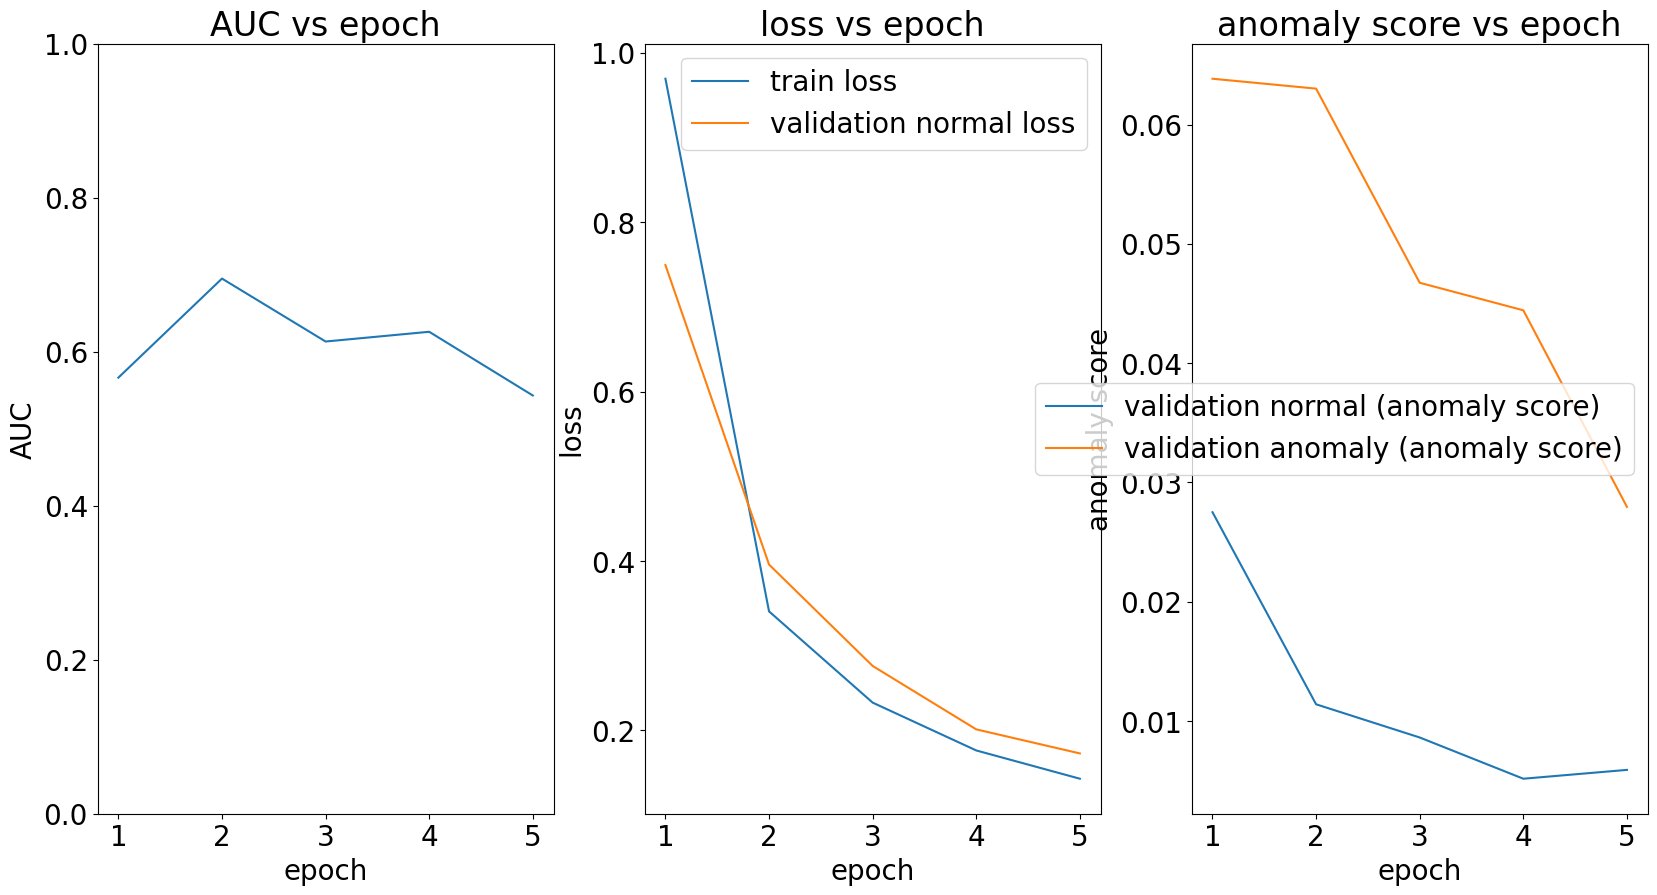

In [16]:
plt.clf()
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(list(range(1,len(roc_auc)+1)),roc_auc)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(1,3,2)
plt.plot(list(range(1,len(train_losses)+1)),train_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend(['train loss', 'validation normal loss'])

plt.subplot(1,3,3)
plt.plot(list(range(1,len(val_normal_scores)+1)),val_normal_scores)
plt.plot(list(range(1,len(val_anomaly_scores)+1)),val_anomaly_scores)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal (anomaly score)','validation anomaly (anomaly score)'])

## 7. Performance on test data.
### 7-1. ROC-AUC

AUC: 0.592
normal loss : 0.4743332862854004


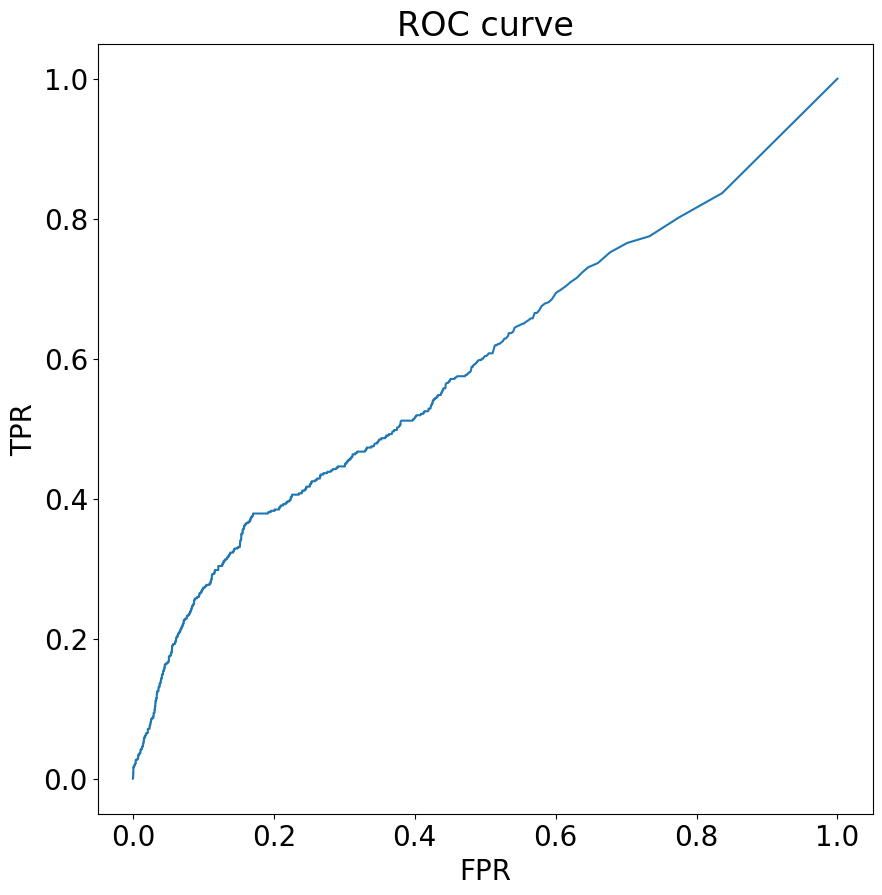

In [17]:
test_auc,_, test_normal_score, test_anomaly_score, test_normal_scores, test_anomaly_scores, best_features, total_labels \
= test(test_dataloader, best_model, loss_fn, valid_mode=False, draw_mode=True, temp_sc = TEMPSC)

### 7-2. Histogram of anomaly score

<Figure size 1000x1000 with 0 Axes>

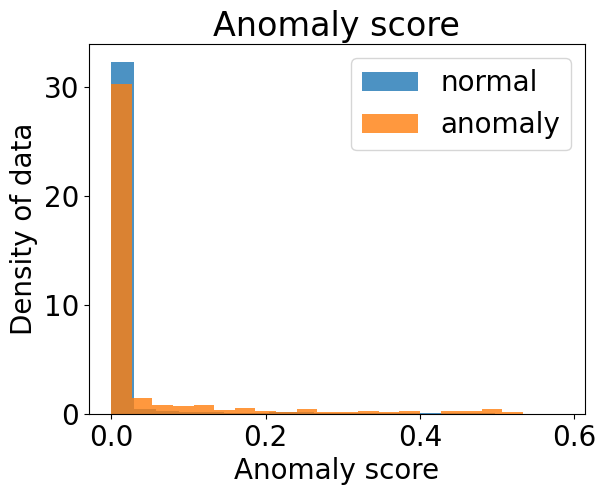

<Figure size 1000x1000 with 0 Axes>

In [18]:
plt.hist(test_normal_scores,  bins = 20, alpha = 0.8, density = True) # 'bins' are related to the number of bins.
plt.hist(test_anomaly_scores, bins = 20, alpha = 0.8, density = True)
plt.title('Anomaly score')
plt.xlabel('Anomaly score')
plt.ylabel('Density of data')
plt.legend(['normal','anomaly'])
plt.figure(figsize=(10,10))

## 8. Image comparison

Below code plots figure of the original input image and predicted probability for each class.

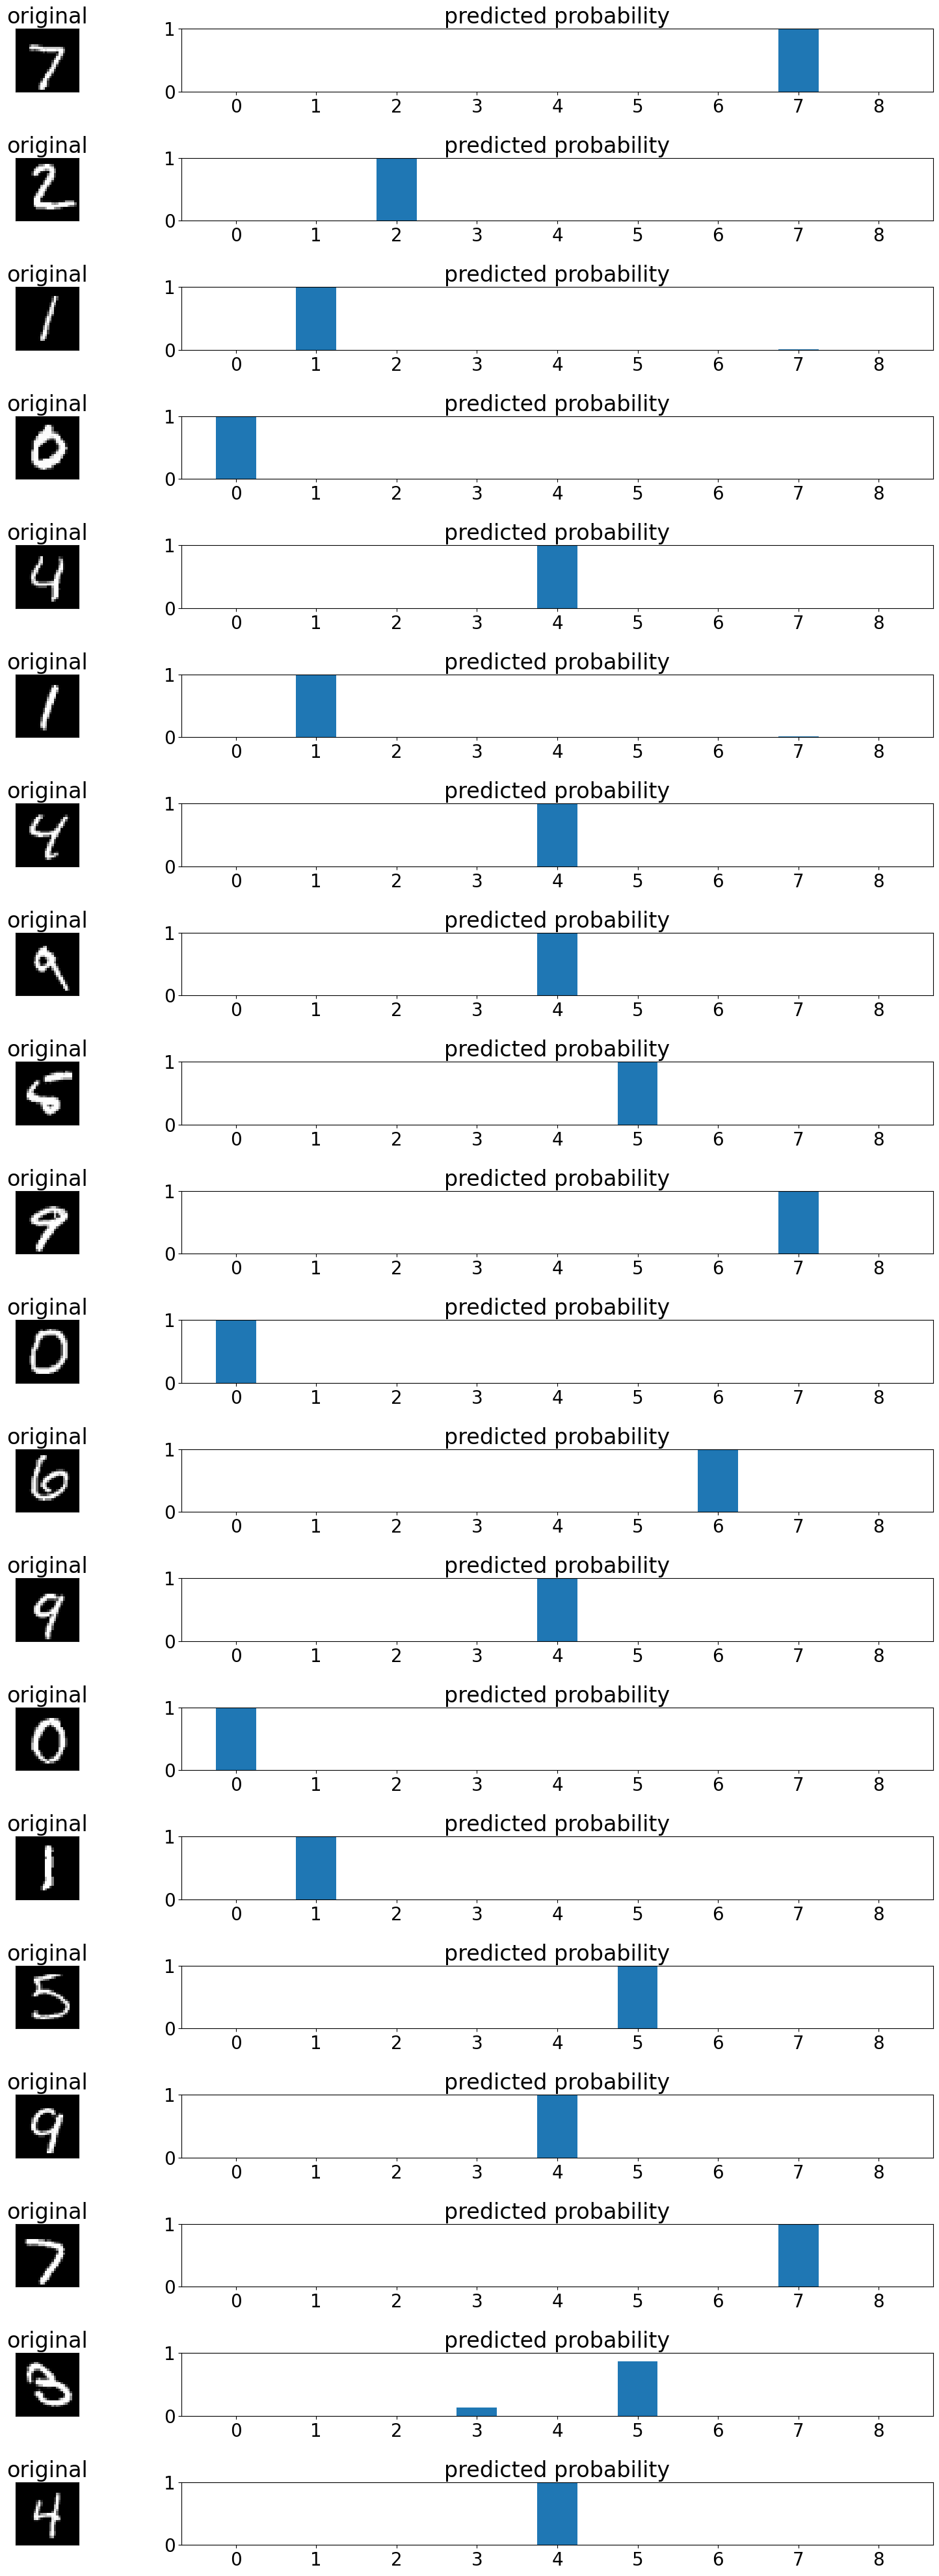

In [19]:
n = 20 # the number of data to be plotted
plt.figure(figsize=(20, 40)) # total figure size

for i in range(n):
    input_image = test_dataset[i][0].to(device)
    pred_prob = torch.softmax(SCALE*best_model.getcosine(input_image.unsqueeze(0),mode = 1)[0],dim=1).cpu().detach().squeeze().numpy()

    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(input_image[0].cpu()) # show input image
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax2 = plt.subplot(n, 2, 2*i+2)
    ax2.set_ylim([0,1])

    classify_as = [str(i) for i in NORMAL_NUM]
    plt.bar(classify_as, pred_prob, width = 0.5, tick_label = classify_as) # print predicted probability for each class

    plt.title('predicted probability')
    plt.tight_layout()

plt.show()

# 9. Visualization
Here, we visualize the feature space and its 2D mapping using t-SNE visualization tool

In [26]:
import plotly.express as px
import numpy as np
import plotly.graph_objects as go

n_colors = ORGCLASS_NUM
colors = px.colors.sample_colorscale("turbo", [n/(n_colors -1) for n in range(n_colors)])

trace = go.Scatter3d(
    x= best_features[:,0],
    y= best_features[:,1],
    z= best_features[:,2],
    mode = 'markers',
    marker=dict(
        size=0.5,
        color=total_labels,                # set color to an array/list of desired values
        cmax=9,
        cmin=0,
        colorscale=colors,
        opacity=0.8,
        colorbar=dict(thickness=20)
    ) )

layout= go.Layout(scene = dict(xaxis = dict(range=[-4,4]),yaxis=dict(range=[-4,4]),zaxis=dict(range=[-4,4]),aspectmode='cube'))
fig = go.Figure(data=[trace], layout=layout)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [27]:
# Create a two dimensional t-SNE projection of the feature embeddings
tsne = TSNE(2, verbose=1) #2D visualization
tsne_proj = tsne.fit_transform(best_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 0.131s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.364616
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.327705
[t-SNE] KL divergence after 1000 iterations: 0.792741


/tmp/ipykernel_1947930/3792846291.py:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



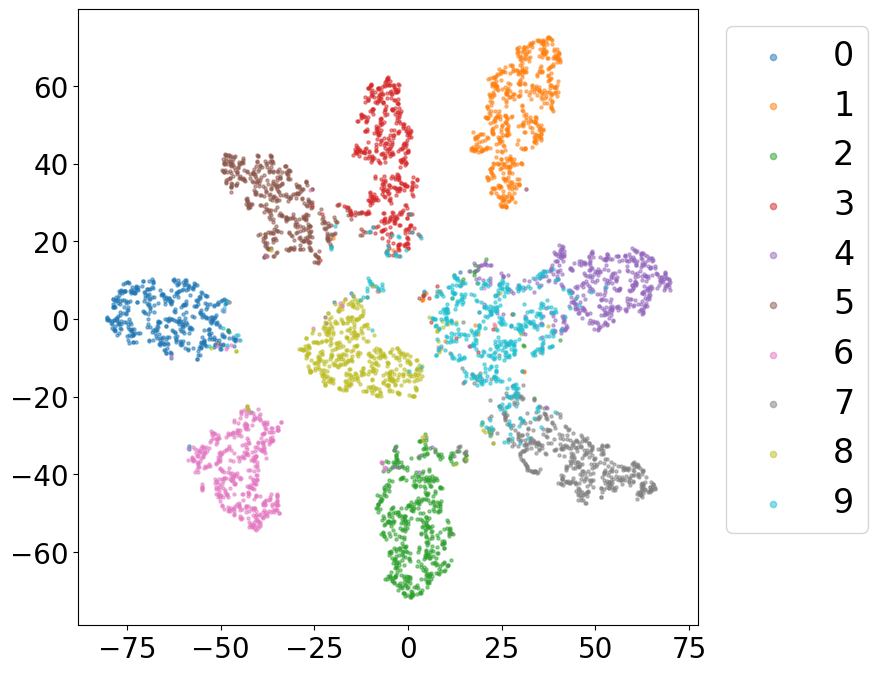

In [28]:
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(8,8))
TOTAL_NUM = NORMAL_NUM + ANOMALY_NUM
num_categories = len(TOTAL_NUM)
for ilabel in TOTAL_NUM:
    indices = total_labels==ilabel
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(ilabel)).reshape(1,4), s=5, label = ilabel ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2, loc='upper right', bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))
plt.show()